# E-commerce Sales Forecasting & Anomaly Detection (V1)

## --- Step 1: Data Cleaning & Preprocessing ---

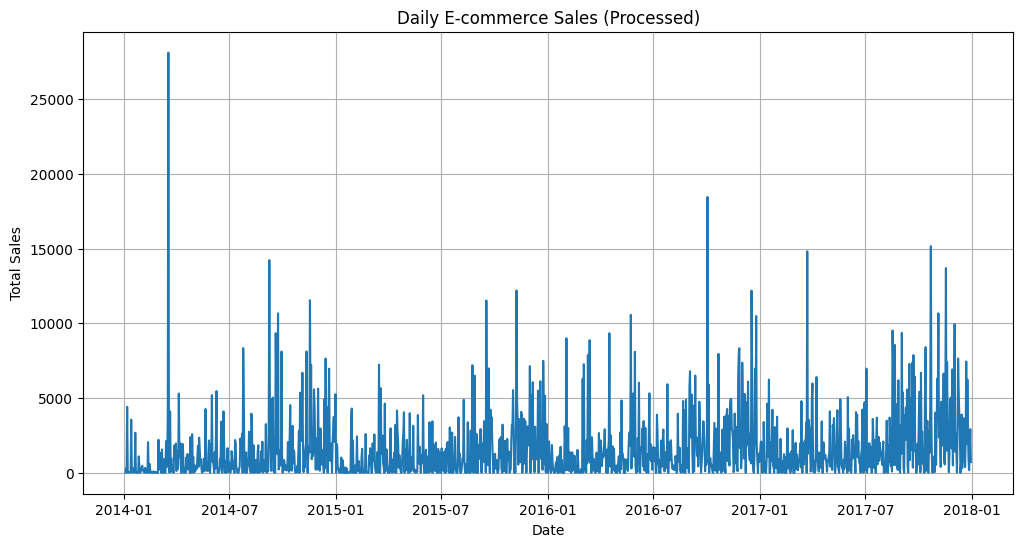

Data Cleaning and Preprocessing Complete. The 'daily_sales' DataFrame is ready for the next step.
          ds         y
0 2014-01-03    16.448
1 2014-01-04   288.060
2 2014-01-05    19.536
3 2014-01-06  4407.100
4 2014-01-07    87.158


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Load the dataset
df = pd.read_csv('Sample - Superstore.csv' , encoding='latin1')

## Step 2: Convert the 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

## Step 3: Aggregate sales by day
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

## Step 4: Reindex and fill missing dates
## This is crucial for time series analysis to ensure a continuous sequence.
## First, set the date as the index.
daily_sales = daily_sales.set_index('Order Date')

# Create a full date range from the min to max date in the data.
full_date_range = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max(), freq='D')

##'important'> Reindex the DataFrame to the full date range and fill missing values with 0.
daily_sales = daily_sales.reindex(full_date_range, fill_value=0)

# The DataFrame is now ready for forecasting. Let's rename the columns for Prophet.
# Prophet requires the columns to be named 'ds' (datestamp) and 'y' (value).
daily_sales = daily_sales.reset_index()
daily_sales.rename(columns={'index': 'ds', 'Sales': 'y'}, inplace=True)

## Step 5: Visualize the preprocessed data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['ds'], daily_sales['y'])
plt.title('Daily E-commerce Sales (Processed)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

print("Data Cleaning and Preprocessing Complete. The 'daily_sales' DataFrame is ready for the next step.")
print(daily_sales.head())

23:24:20 - cmdstanpy - INFO - Chain [1] start processing
23:24:20 - cmdstanpy - INFO - Chain [1] done processing


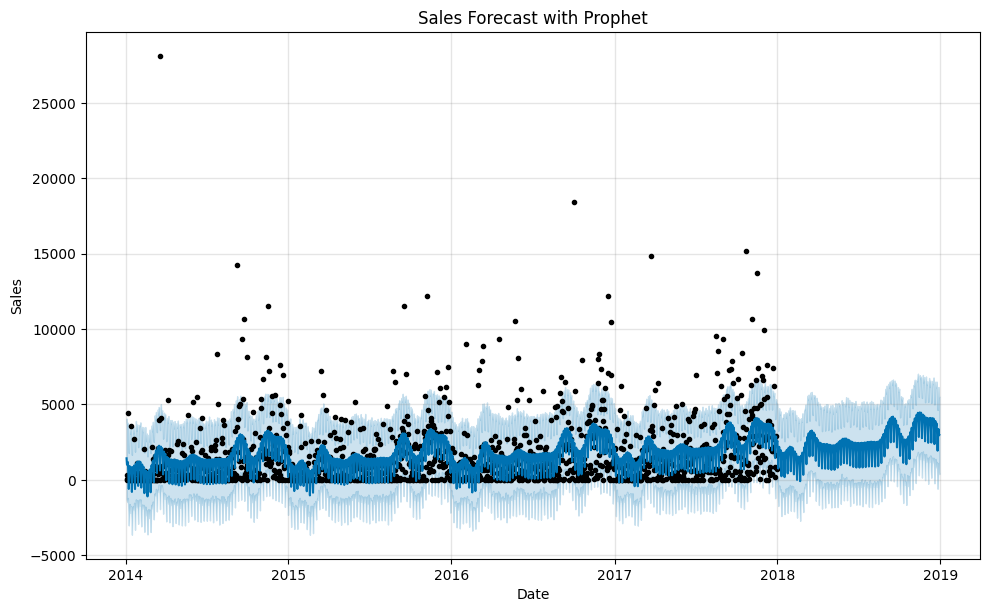

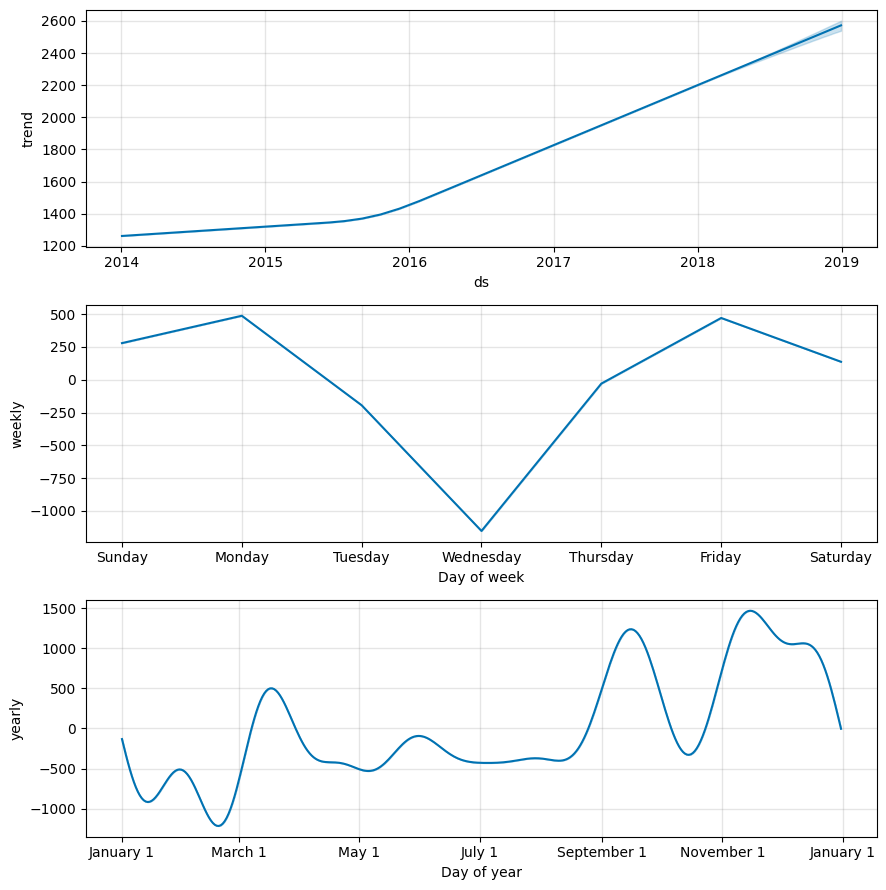

Sales forecasting with Prophet is complete. The 'forecast' DataFrame contains your results.
             ds         yhat   yhat_lower   yhat_upper
1818 2018-12-26  1928.849130  -593.738805  4631.882863
1819 2018-12-27  2962.797539   234.284913  5571.607579
1820 2018-12-28  3368.782253  1119.937544  6149.869563
1821 2018-12-29  2936.660234   474.450512  5483.595029
1822 2018-12-30  2978.097988   381.306493  5516.235064


In [20]:
# Step 2: Sales Forecasting Model (Prophet)
from prophet import Prophet

# Create a new Prophet model instance
m = Prophet()

# Fit the model to your daily sales data
# The daily_sales DataFrame should have columns 'ds' and 'y'
m.fit(daily_sales)

# Create a DataFrame to hold future dates for forecasting
# We will forecast for the next 12 months (365 days)
future = m.make_future_dataframe(periods=365)

# Generate the forecast
forecast = m.predict(future)

# Plot the forecast
fig1 = m.plot(forecast)
plt.title('Sales Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Plot the forecast components
fig2 = m.plot_components(forecast)
plt.show()

print("Sales forecasting with Prophet is complete. The 'forecast' DataFrame contains your results.")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Running Step 1: Data Cleaning & Preprocessing...
Data preprocessing complete. Columns are: Index(['ds', 'y'], dtype='object')
          ds         y
0 2014-01-03    16.448
1 2014-01-04   288.060
2 2014-01-05    19.536
3 2014-01-06  4407.100
4 2014-01-07    87.158

Running Step 3: Anomaly Detection...

Plotting the results...


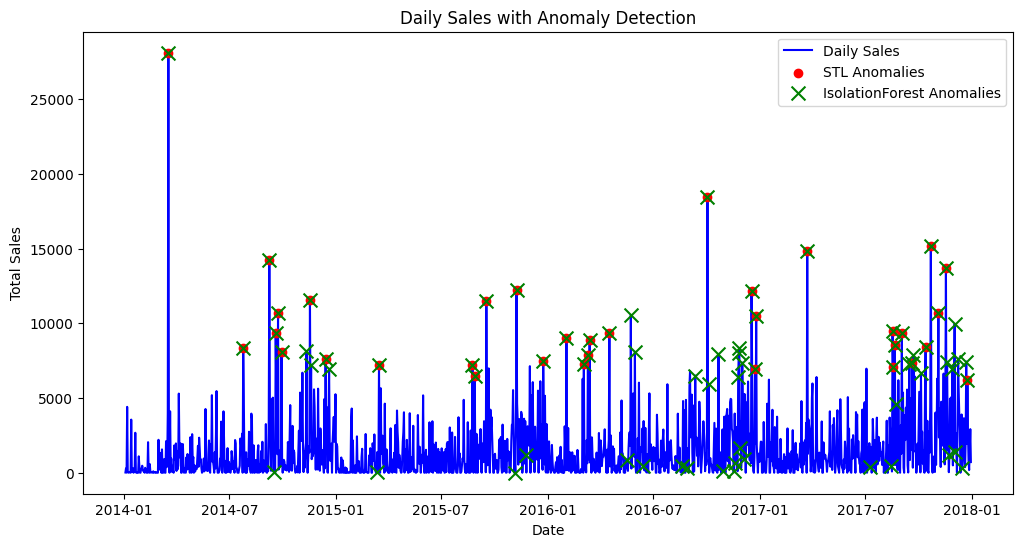


Anomaly detection is complete. The 'daily_sales' DataFrame now contains anomaly flags.
                    y   residuals  stl_anomaly  iforest_anomaly_score  \
ds                                                                      
2017-12-26   814.5940  -58.538071            0              -0.229617   
2017-12-27   177.6360  263.330234            0              -0.197614   
2017-12-28  1657.3508   91.855388            0              -0.203138   
2017-12-29  2915.5340 -227.950896            0              -0.131834   
2017-12-30   713.7900   -9.998946            0              -0.234566   

            iforest_anomaly  
ds                           
2017-12-26                0  
2017-12-27                0  
2017-12-28                0  
2017-12-29                0  
2017-12-30                0  


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from pyod.models.iforest import IForest

# --- Step 1: Data Cleaning & Preprocessing ---
print("Running Step 1: Data Cleaning & Preprocessing...")

# Load the dataset with the correct encoding
df = pd.read_csv('Sample - Superstore.csv', encoding='latin1')

# Convert the 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregate sales by day
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

# Reindex to a full date range and fill missing values with 0
daily_sales = daily_sales.set_index('Order Date').reindex(
    pd.date_range(start=daily_sales['Order Date'].min(), end=daily_sales['Order Date'].max(), freq='D'),
    fill_value=0
).reset_index()

# Correctly rename the columns for Prophet and later steps
daily_sales.rename(columns={'index': 'ds', 'Sales': 'y'}, inplace=True)
print("Data preprocessing complete. Columns are:", daily_sales.columns)
print(daily_sales.head())

# --- Step 3: Anomaly Detection ---
print("\nRunning Step 3: Anomaly Detection...")

# Set the date column as the index for time-series analysis
daily_sales = daily_sales.set_index('ds')

# Layer A: Statistical Anomaly Detection using STL
res = STL(daily_sales['y'], period=7, robust=True).fit()
daily_sales['residuals'] = res.resid

# Calculate a statistical threshold for anomalies (3 times the standard deviation)
threshold = 3 * daily_sales['residuals'].std()

# Flag anomalies based on the threshold
daily_sales['stl_anomaly'] = np.where(np.abs(daily_sales['residuals']) > threshold, 1, 0)

# Layer B: Model-based Anomaly Detection using IsolationForest
# Create a feature set for the model
X = daily_sales[['y', 'residuals']].values

# Initialize and train the Isolation Forest model
clf = IForest(contamination=0.05, random_state=42)
clf.fit(X)

# Get the anomaly scores and prediction labels
daily_sales['iforest_anomaly_score'] = clf.decision_scores_
daily_sales['iforest_anomaly'] = clf.labels_

# --- Visualization ---
print("\nPlotting the results...")
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['y'], label='Daily Sales', color='blue')

# Plot the statistical anomalies from Layer A
plt.scatter(
    daily_sales.index[daily_sales['stl_anomaly'] == 1],
    daily_sales['y'][daily_sales['stl_anomaly'] == 1],
    color='red',
    label='STL Anomalies',
    zorder=5
)

# Plot the model-based anomalies from Layer B
plt.scatter(
    daily_sales.index[daily_sales['iforest_anomaly'] == 1],
    daily_sales['y'][daily_sales['iforest_anomaly'] == 1],
    color='green',
    marker='x',
    s=100,
    label='IsolationForest Anomalies',
    zorder=6
)

plt.title('Daily Sales with Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

# Print a confirmation and the final DataFrame
print("\nAnomaly detection is complete. The 'daily_sales' DataFrame now contains anomaly flags.")
print(daily_sales.tail())

In [42]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Prepare data for plotting
sales_data = go.Scatter(
    x=daily_sales.index,
    y=daily_sales['y'],
    mode='lines',
    name='Daily Sales',
    line=dict(color='blue')
)

# Prepare STL anomalies for plotting
stl_anomalies = go.Scatter(
    x=daily_sales[daily_sales['stl_anomaly'] == 1].index,
    y=daily_sales['y'][daily_sales['stl_anomaly'] == 1],
    mode='markers',
    name='STL Anomalies',
    marker=dict(color='red', size=8, symbol='circle'),
    hovertemplate='Date: %{x}<br>Sales: %{y}<br>Anomaly Type: STL<extra></extra>'
)

# Prepare IsolationForest anomalies for plotting
iforest_anomalies = go.Scatter(
    x=daily_sales[daily_sales['iforest_anomaly'] == 1].index,
    y=daily_sales['y'][daily_sales['iforest_anomaly'] == 1],
    mode='markers',
    name='IsolationForest Anomalies',
    marker=dict(color='green', size=10, symbol='x'),
    hovertemplate='Date: %{x}<br>Sales: %{y}<br>Anomaly Type: IsolationForest<extra></extra>'
)

# Create the figure and add all traces
fig = go.Figure(data=[sales_data, stl_anomalies, iforest_anomalies])

# Update layout for a cleaner look and add title/axes labels
fig.update_layout(
    title='Daily Sales with Anomaly Detection',
    xaxis_title='Date',
    yaxis_title='Total Sales',
    xaxis_rangeslider_visible=True,
    template="plotly_white"
)

# Display the interactive plot
iplot(fig)

print("Interactive Plotly dashboard created!")

Interactive Plotly dashboard created!
